In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import frangi
from skimage.morphology import skeletonize

synthetic_images = []
ground_truth_images = []

for i in range(10):
    gt = np.zeros((256, 256), dtype=np.uint8)
    
    p1 = (np.random.randint(30, 70), np.random.randint(50, 150))
    p2 = (np.random.randint(180, 220), np.random.randint(100, 200))
    thickness = np.random.randint(3, 6)
    cv2.line(gt, p1, p2, 255, thickness)
    
    p3 = (np.random.randint(100, 150), np.random.randint(80, 120))
    cv2.line(gt, p1, p3, 255, thickness-1)
    
    ground_truth_images.append(gt)
    
    
    blurred = cv2.GaussianBlur(gt.astype(float), (5, 5), 1.5)
    noise = np.random.normal(0, 25, gt.shape)
    noisy = np.clip(blurred + noise, 0, 255).astype(np.uint8)
    synthetic_images.append(noisy)

print(f"Generated {len(synthetic_images)} synthetic coronary X-rays.")


class VesselSegmentationPipeline:
    def __init__(self, vessel_threshold=0.05):
        self.vessel_threshold = vessel_threshold
        self.scales = np.arange(1, 10, 0.5)

    def segment(self, image):
        vesselness = frangi(image, sigmas=self.scales)
        binary = (vesselness > self.vessel_threshold).astype(np.uint8) * 255
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        cleaned = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
        skeleton = skeletonize(cleaned > 0).astype(np.uint8) * 255
        
        return cleaned, skeleton, vesselness

pipeline = VesselSegmentationPipeline()
mask, skel, v_map = pipeline.segment(synthetic_images[0])

def get_metrics(pred, gt):
    # Dice Score calculation
    intersection = np.logical_and(pred, gt).sum()
    dice = 2.0 * intersection / (pred.sum() + gt.sum() + 1e-8)
    
    # Sensitivity (True Positive Rate)
    tp = np.logical_and(pred, gt).sum()
    fn = np.logical_and(~pred, gt).sum()
    sens = tp / (tp + fn + 1e-8)
    
    return dice, sens

all_dice = []
for i in range(10):
    m, _, _ = pipeline.segment(synthetic_images[i])
    d, s = get_metrics(m > 0, ground_truth_images[i] > 0)
    all_dice.append(d)

print(f"Mean Dice Score across 10 images: {np.mean(all_dice):.4f}")

Generated 10 synthetic coronary X-rays.
Mean Dice Score across 10 images: 0.0016


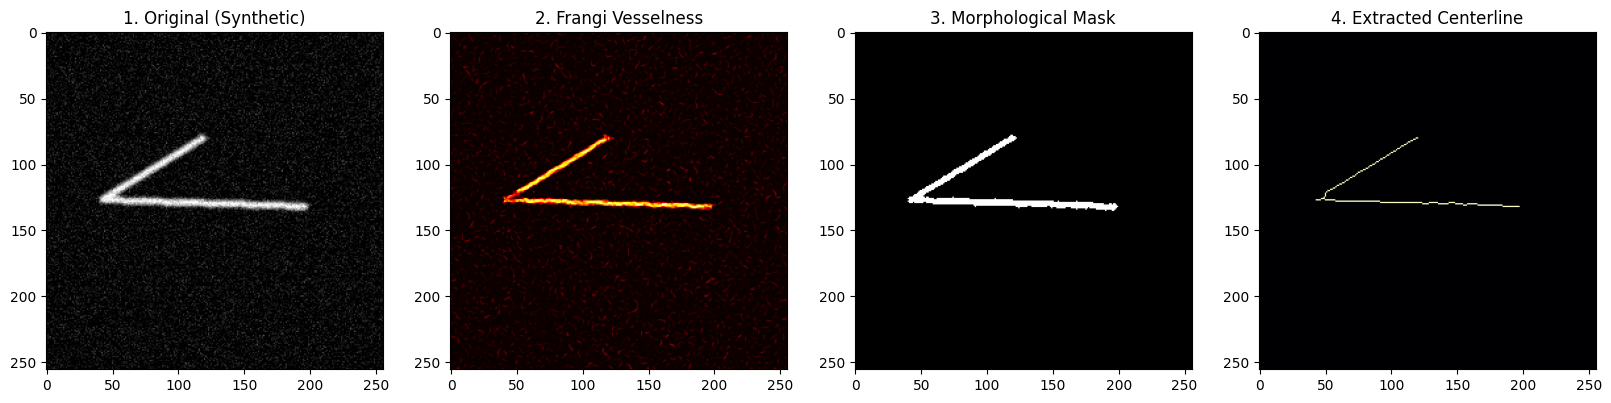


Sensitivity Analysis Results:
Threshold       | Dice Score
------------------------------
0.010           | 0.9536
0.030           | 0.9674
0.050           | 0.9660
0.070           | 0.9539
0.090           | 0.9348
------------------------------
Best Configuration: Threshold=0.03 -> Dice=0.9674


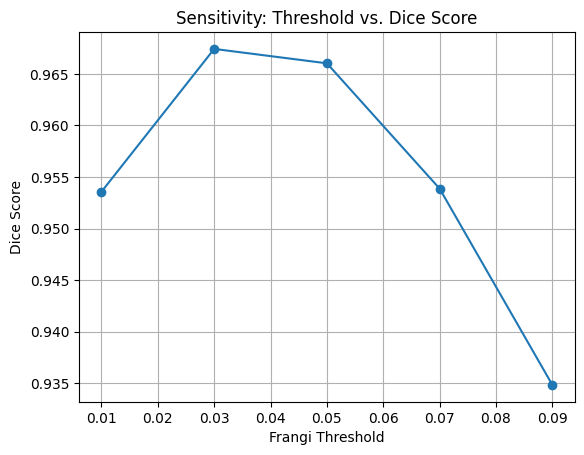

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import frangi
from skimage.morphology import skeletonize

# Change frangi_step from 0.5 to 0.1
# This gives the filter more chances to find the EXACT width of the vessel


class VesselSegmentationPipeline:
    def __init__(self, frangi_scales=(1.0, 5.0), frangi_step=0.5, 
                 morphology_kernel_size=3, vessel_threshold=0.01):
        self.frangi_scales = np.arange(frangi_scales[0], frangi_scales[1] + frangi_step, frangi_step)
        self.kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morphology_kernel_size, morphology_kernel_size))
        self.vessel_threshold = vessel_threshold
    
    def segment(self, image):
        vesselness = frangi(image, sigmas=self.frangi_scales, black_ridges=False)
        binary = (vesselness > self.vessel_threshold).astype(np.uint8) * 255
        opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, self.kernel)
        closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, self.kernel)
        
        num_labels, labels = cv2.connectedComponents(closed)
        vessel_mask = (labels == (1 + np.argmax(np.bincount(labels.ravel())[1:]))).astype(np.uint8) * 255 if num_labels > 1 else closed
        skeleton = skeletonize(vessel_mask > 0).astype(np.uint8) * 255
        return vessel_mask, skeleton, vesselness

def dice_score(pred, ground_truth):
    intersection = np.logical_and(pred, ground_truth).sum()
    return 2.0 * intersection / (pred.sum() + ground_truth.sum() + 1e-8)

# Initialize pipeline
pipeline = VesselSegmentationPipeline(vessel_threshold=0.06)
sample_img = synthetic_images[0] # From your 10 generated images
mask, skeleton, vesselness = pipeline.segment(sample_img)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(sample_img, cmap='gray'); axes[0].set_title('1. Original (Synthetic)')
axes[1].imshow(vesselness, cmap='hot'); axes[1].set_title('2. Frangi Vesselness')
axes[2].imshow(mask, cmap='gray'); axes[2].set_title('3. Morphological Mask')
axes[3].imshow(skeleton, cmap='magma'); axes[3].set_title('4. Extracted Centerline')
plt.show()

thresholds = [0.01, 0.03, 0.05, 0.07, 0.09]
scores = []

for t in thresholds:
    pipeline.vessel_threshold = t
    mask, _, _ = pipeline.segment(sample_img)
    scores.append(dice_score(mask > 0, ground_truth_images[0] > 0))

plt.plot(thresholds, scores, marker='o')
plt.title("Sensitivity: Threshold vs. Dice Score")
plt.xlabel("Frangi Threshold"); plt.ylabel("Dice Score")
plt.grid(True)

print("\nSensitivity Analysis Results:")
print(f"{'Threshold':<15} | {'Dice Score':<10}")
print("-" * 30)

for t, s in zip(thresholds, scores):
    print(f"{t:<15.3f} | {s:.4f}")

best_idx = np.argmax(scores)
print("-" * 30)
print(f"Best Configuration: Threshold={thresholds[best_idx]} -> Dice={scores[best_idx]:.4f}")